In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import utilis

# Exercise 6 - Simple features

Solving the correspondance problem in computer vision is done in a three step process:
- Recognize features in each image.
- Recognize patterns of features, that corresponds between each image. So called descriptors.
- Match the descriptors.

In this week we will focus on the features or key points in a single image. What is important is that such features should be recognizable even if the image is rotated, translated or enhanced - so that it is possible to find the same features in multiple images. One such good feature is a corner point, as in a corner the image gradient (describing how the color itensity changes in an area) is changing a lot when moving slightly away from the corner. Similarly edges can be a good, but not as poweful feature. Edges are however a more useful feature in many cases, as they are often required to navigate or detect more advanced structures.

Programming exercise: Harris corner detector

### Harris corner detection

Harris corner detection relies on calculating the "cornerness" of each area of an image, using $c(x,y) = g * \delta I(x,y)^2$. Where g is a gaussian kernel to blurr the image, making it less suseptable to noise, and the delta I is the gradient in a small area around a point x,y. 

Using a first order taylor polynomial to approximate the gradient we get the average Hessian matrix: $c(x,y) = \delta^T * C(x,y) * \delta$.

delta is a small vector, representing a small shift away from x,y in any direction. The harrison metric is to look at $r(x,y) = det(C) - k * trace(C) = \lambda _1 \lambda _2 - k*(\lambda _1 + \lambda _2)$, where k is a free parameter, typically 0.06. r(x,y) is ...:
- r > 0: Corners (both large lambdas) - so the gradient moves a lot in both directions.
- r < 0: edges (one lambda big, one small) - so the gradient changes a lot more while moving along one axis then the other.
- Both lambdas small? Typically a flat area/surface.

#### 6.1 Gaussian kernel g

Size of gaussian filter is given by the 3, 4, or 5 sigma rule:
- How far do you want to extend the filter? To capture 100% of gaussian distribution you need (-inf, inf). But if you make it 2 * 5 * sigma (2 since you go on both sides of $\mu$), then you capture 99.7% of the distribution.

In [2]:
# #smooth the image to reduce noise and avoid detecting false edges.

def gaussian_1D_kernel(sigma, rule=1):
    """
    Returns the 1D Gaussian kernel.

    Args:
        sigma: width of Gaussian kernel
        size (int): number of standard deviations to each side of the mean

    Returns:
        g: 1D Gaussian kernel
        gd: 1D Gaussian kernel derivative
    """
    if sigma == 0:
        return [1], [0]
    x = np.arange(-rule * sigma, rule * sigma + 1)
    g = gaussian(x,sigma)
    g = g / np.sum(g)  # normalize
    gd = gausDerivative(x,sigma)
    return g, gd

def gaussian(x,sigma):
    return np.exp(-x**2 / (2*sigma**2))

def gausDerivative(x,sigma):
    return -(x/sigma)*gaussian(x,sigma)


In [3]:
sigma = 3
g, gd = gaussian_1D_kernel(sigma)
print(f"Gaussian kernel: {g.shape}\n{g}")
print(f"Gaussian kernel derivative: {gd.shape}\n{gd}")

Gaussian kernel: (7,)
[0.10628852 0.14032134 0.16577007 0.17524014 0.16577007 0.14032134
 0.10628852]
Gaussian kernel derivative: (7,)
[ 0.60653066  0.53382494  0.31531982 -0.         -0.31531982 -0.53382494
 -0.60653066]


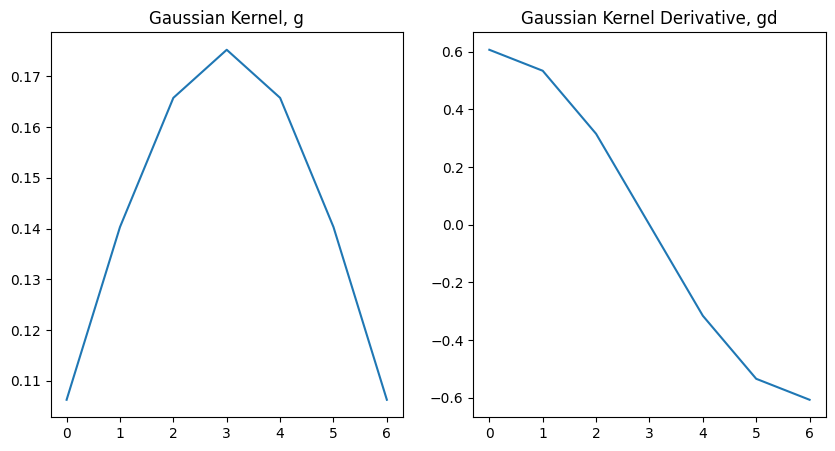

In [4]:
# Plotting as line plots
figure, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(g)
ax[0].set_title('Gaussian Kernel, g')
ax[1].plot(gd)
ax[1].set_title('Gaussian Kernel Derivative, gd')
plt.show()

#### 6.2 Gaussian smoothing

The fact that gaussian is seperable, we can smooth one direction (x, y) at a time, using the same kernel, or different ones. The end result is not affected by the order of smoothings (commutative). 

Getting the derivatives of an image can be done using the gaussian to blurr the image first: to make the image into a nice smooth differentiatable surface, and then using the derivative of the gaussian to differentiate the image. What is differentiating an image? It is to see how quickly the color intensity of the iamge changes in all directions => which is what we gain by using the gx kernel.

In [5]:
# Apply the Gaussian kernel to the input image
def gaussian_smoothing(im, sigma):
    """
    Smooths the input image with a 1D Gaussian kernel.

    Args:
        im : input image
        sigma : width of Gaussian kernel

    Returns:
        I : smoothed image
        Ix : image derivative in x-direction
        Iy : image derivative in y-direction
    """
    g, gd = gaussian_1D_kernel(sigma)
    I = cv2.sepFilter2D(im, -1, g, g)
    Ix = cv2.sepFilter2D(im, -1, gd, g)
    Iy = cv2.sepFilter2D(im, -1, g, gd)
    return I, Ix, Iy

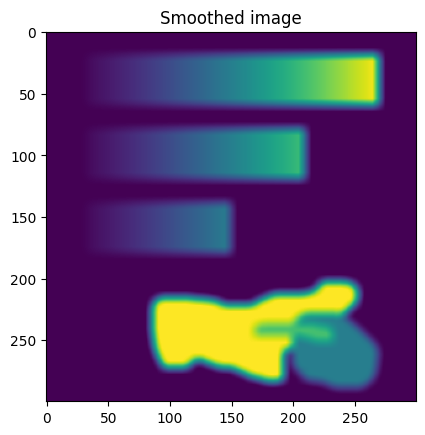

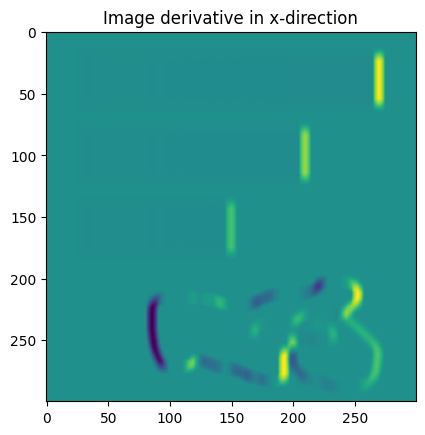

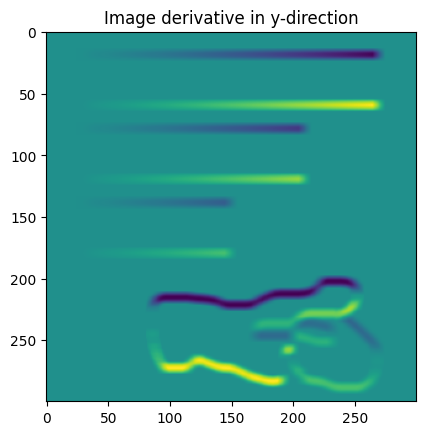

In [6]:
im = "images/TestIm2.png"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
sigma = 5
I, Ix, Iy = gaussian_smoothing(im, sigma)

# Display images
plt.imshow(I)
plt.title("Smoothed image")
plt.show()

plt.imshow(Ix)
plt.title("Image derivative in x-direction")
plt.show()

plt.imshow(Iy)
plt.title("Image derivative in y-direction")
plt.show()

#### 6.3 Smooth / average hessian

A key component in the Harris corner detection is the smooth hessian of the image. The eigenvalues / dynamics of the hessian matrix gives how quickly the gradient is changing in the different directions.

Now create the function C = structureTensor(im, sigma, epsilon) where and gϵ ∗ . . . is the convolution of a new Gaussian kernel with width epsilon

The structure tensor is a tool used in computer vision to detect corners and edges in images, and it provides information about the direction of edges and the texture of the image region.

calculating the structure tensor at each pixel (x, y) of the image im. The notation involves several operations, including gradients (Ix, Iy for x and y directions, respectively) and Gaussian smoothing (gϵ ∗). The structure tensor for each pixel is a 2x2 matrix obtained from the gradients of the image:

Ix^2, Iy^2, and IxIy are the products of the gradients at each pixel, indicating the intensity change rates in the image.
g_\epsilon represents the Gaussian smoothing with a kernel of width epsilon, applied to smooth the gradient products across the image. This smoothing is crucial for incorporating the local image structure information around each pixel.

In [7]:
def structure_tensor(im, sigma, epsilon):
    I, Ix, Iy = gaussian_smoothing(im, sigma)

    g_eps, g_eps_d = gaussian_1D_kernel(epsilon)
    Ix_Iy = cv2.sepFilter2D(Ix * Iy, -1, g_eps, g_eps)
    Ix_x = cv2.sepFilter2D(Ix**2, -1, g_eps, g_eps)
    Iy_y = cv2.sepFilter2D(Iy**2, -1, g_eps, g_eps)
    C = np.array([[Ix_x, Ix_Iy],
                  [Ix_Iy, Iy_y]])
    return C

A key component in the Harris corner detection is the smooth hessian of the image. The eigenvalues / dynamics of the hessian matrix gives how quickly the gradient is changing in the different directions.

Structure tensor: (2, 2, 300, 300)


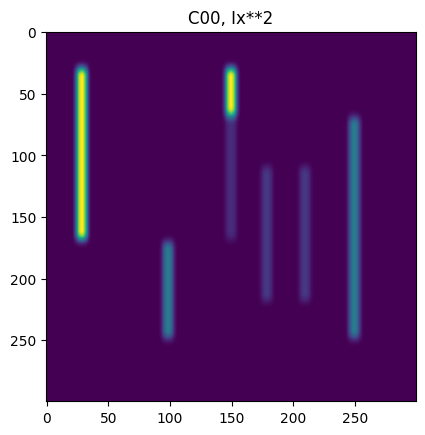

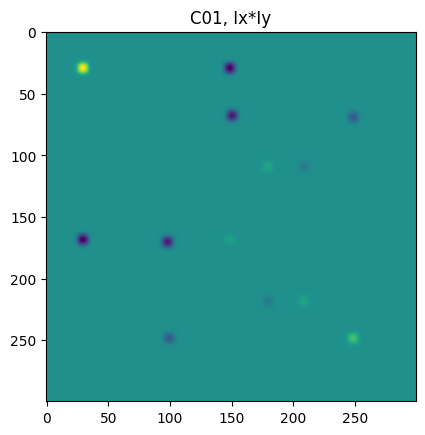

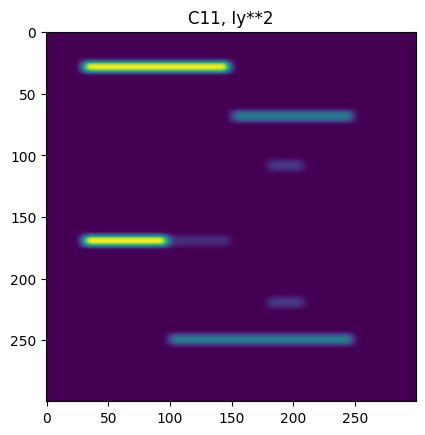

In [8]:
im = 'images/TestIm1.png'
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
sigma = 4
epsilon = 4
C = structure_tensor(im, sigma, epsilon)

print(f"Structure tensor: {C.shape}")
# Display images
plt.imshow(C[0, 0])
plt.title("C00, Ix**2")
plt.show()

plt.imshow(C[0, 1])
plt.title("C01, Ix*Iy")
plt.show()

plt.imshow(C[1, 1])
plt.title("C11, Iy**2")
plt.show()

Width and Height of the Image: The first two dimensions correspond to the spatial dimensions of the image, i.e., its width and height. For an image with a resolution of WxH, these dimensions allow you to index any pixel in the image.

Structure Tensor Matrix Size: For each pixel, the structure tensor is a 2x2 matrix, accounting for the changes in the x and y directions. This introduces two more dimensions to store the 2x2 matrix at each pixel location, leading to the four-dimensional shape of C.

Therefore, the shape of C could be described as (Height, Width, 2, 2), where the last two dimensions are used to store the structure tensor matrix for each pixel in the image.

Exercise 6.4
Create the function r = harrisMeasure(im, sigma, epsilon, k) where

In [9]:
def harris_measure(im, sigma, epsilon, k):
    """
    Computes the Harris measure R(x,y) of the input image.

    Args:
        im : (h,w) input image
        sigma : Gaussian width to compute derivatives
        epsilon : Gaussian width to compute the structure tensor
        k : sensitivity factor

    Returns:
        r : (h,w), Harris measure
    """
    C = structure_tensor(im, sigma, epsilon)
    a = C[0, 0]
    b = C[1, 1]
    c = C[0, 1]
    r = a * b - c**2 - k * (a + b) ** 2
    return r


r: (300, 300)


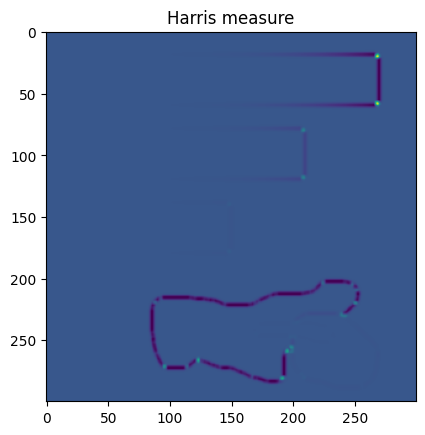

In [10]:
im = "images/TestIm1.png"
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)

im2 = "images/TestIm2.png"
im2 = cv2.imread(im2, cv2.IMREAD_GRAYSCALE).astype(float)
k = 0.06
r = harris_measure(im2, 2, 2, k)
print(f"r: {r.shape}")
# Display images
plt.imshow(r)
plt.title("Harris measure")
plt.show()
# When epsilon is zero, the Gaussian distribution becomes a delta function,
# and the structure tensor becomes a constant tensor. There will not be any
# blurring in place. And the equations will be undefined.

k is a sensitivity factor that influences the detection of corners
epsilon defines the width of the Gaussian kernel for smoothing the gradient products, crucial for integrating local information and achieving noise robustness.

Setting epsilon = 0 effectively means no Gaussian smoothing is applied to the gradient products (Ix2, Iy2, Ixy). This absence of smoothing would result in a high sensitivity to noise and possibly lead to detecting false corners due to minor, irrelevant variations in the gradient data.

#### 6.5 Non max supression 

Finally, create the function c = cornerDetector(im, sigma, epsilon, k, tau) where c is a
list of points where r is the local maximum and larger than some relative threshold i.e

In [11]:
# Ex 6.5
# Corner detection with non-max suppression
def corner_detector(im, sigma, epsilon, tau, k):
    """
    Detects corners in the input image using the Harris measure
    with non-max suprrssion and thresholding.

    Args:
        im : input image
        sigma : Gaussian width to compute derivatives
        epsilon : Gaussian width to compute the structure tensor
        tau : threshold for Harris measure
        k : sensitivity factor

    Returns:
        c : list of corner coordinates
    """
    r = harris_measure(im, sigma, epsilon, k)
    print(f"r: [{r.max():.2f}, {r.min():.2f}], tau = {tau/r.max():.2f}*r.max")

    # Perform 4-neigbourhood non-max suppression
    c = []
    for i in range(1, r.shape[0] - 1):
        for j in range(1, r.shape[1] - 1):
            if (
                r[i, j] > r[i + 1, j]
                and r[i, j] >= r[i - 1, j]
                and r[i, j] > r[i, j + 1]
                and r[i, j] >= r[i, j - 1]
                and r[i, j] > tau
            ):  # Threshold
                c.append([i, j])
    return c


1000
r: [295790141.66, -109581200.43], tau = 0.00*r.max
38 corners found.
[[20, 268], [58, 268], [80, 208], [118, 208], [140, 148], [178, 148], [204, 224], [205, 248], [206, 247], [209, 252], [210, 250], [220, 88], [220, 250], [230, 239], [231, 242], [233, 211], [235, 204], [236, 203], [239, 171], [241, 230], [245, 170], [247, 198], [247, 201], [248, 202], [250, 231], [256, 199], [259, 195], [259, 199], [260, 198], [266, 123], [270, 113], [271, 96], [271, 114], [278, 207], [280, 209], [281, 191], [286, 255], [288, 256]]


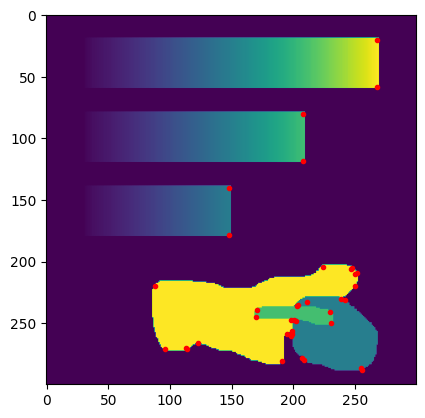

In [12]:
# For TestIm2.png, the r-values are very high at the perfect corners.
# That's why the threshold is set below the recommended 0.1*r.max
im = 'images/TestIm2.png'
im = cv2.imread(im, cv2.IMREAD_GRAYSCALE).astype(float)
tau = 1000
print(tau)
c = corner_detector(im, 2, 2, tau, 0.06)
print(f"{len(c)} corners found.")
print(c)

# Display corners
plt.imshow(im)
for pt in c:
    plt.plot(pt[1], pt[0], "r.")
plt.show()

### Canny edge detection

Just like many other imaging operations the Canny edge detector is available in both Matlab and \
OpenCV. Instead of implementing it ourselves, let us start using someone else’s implementation.

#### 6.6 Testing Canny

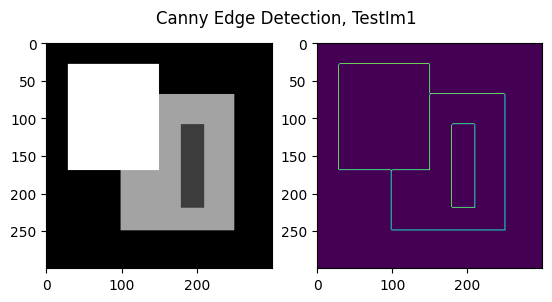

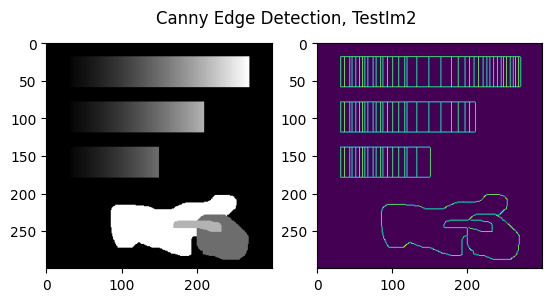

In [13]:
# Canny edge detector

im1 = cv2.imread("images/TestIm1.png", cv2.IMREAD_GRAYSCALE)
# plt.imshow(im1)
# plt.show()

# Loading astype(float) does not work for canny edge
t1 = 0
t2 = 10
edges_1 = cv2.Canny(im1, t1, t2)
plt.suptitle(
    "Canny Edge Detection, TestIm1", y=0.8
)  # y controls title position
plt.subplot(121), plt.imshow(im1, cmap="gray")
plt.subplot(122), plt.imshow(edges_1)
plt.show()

im2 = cv2.imread("images/TestIm2.png", cv2.IMREAD_GRAYSCALE)
edges_2 = cv2.Canny(im2, t1, t2)
plt.suptitle("Canny Edge Detection, TestIm2", y=0.8)
plt.subplot(121), plt.imshow(im2, cmap="gray")
plt.subplot(122), plt.imshow(edges_2)
plt.show()

#### 6.7 What is the effect of the threshold parameter?


The thresholds decides which of all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded.

300


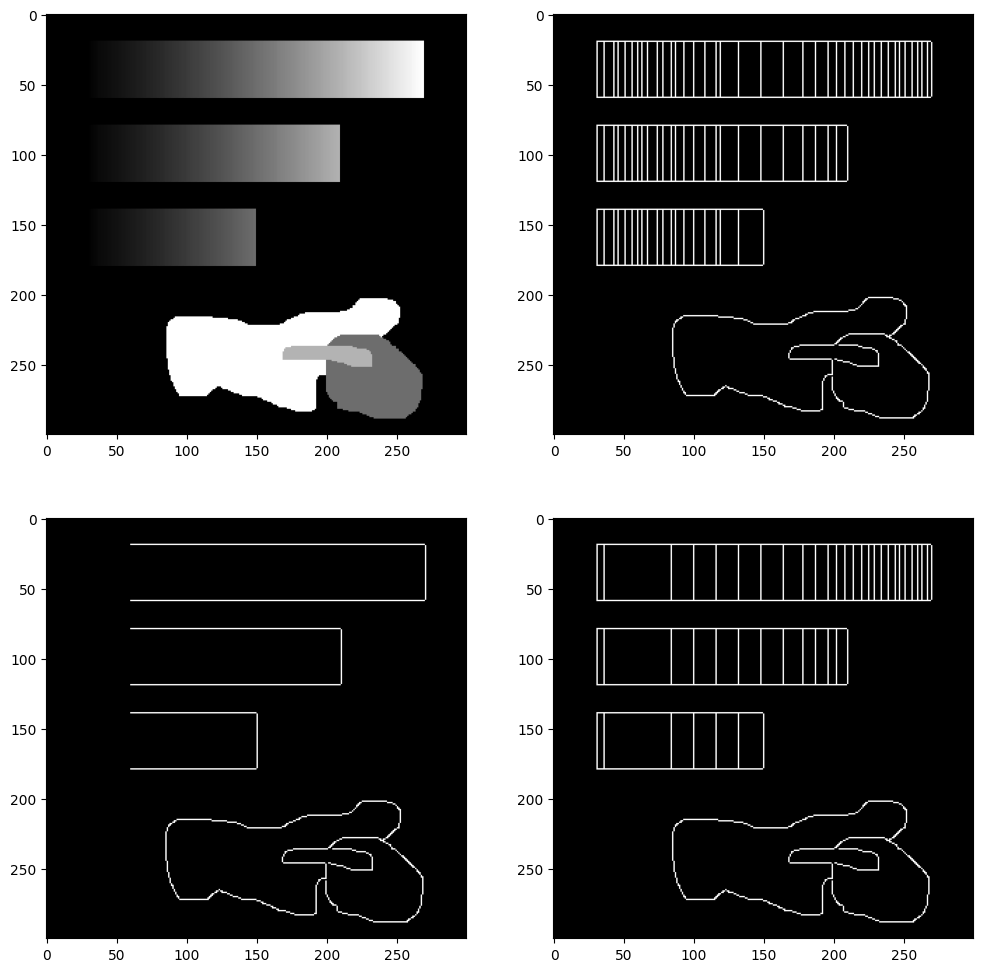

In [18]:
edges_1 = cv2.Canny(im2, 0, 10) # All above 10 are concidered edges, and all others are also edges if they are connected!
edges_2 = cv2.Canny(im2, 100, 100) # All above 100 are edges, all below are not.
edges_3 = cv2.Canny(im2, 10, 50) # All below 30 are not, all above 50 are, all in between are edges if connected.
print(len(edges_3))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax[0, 0].imshow(im2, cmap="gray")
ax[0, 1].imshow(edges_1, cmap="gray")
ax[1, 0].imshow(edges_2, cmap="gray")
ax[1, 1].imshow(edges_3, cmap="gray")

*Low threshold*: This value sets the lower bound for edge detection. Gradients weaker than this threshold are ignored. This means that any pixel intensity gradient less than the low threshold is considered not to be an edge, and thus ignored in the final edge map. 

*High threshold*: This value sets the upper bound for edge detection. Any gradient value higher than this threshold is sure to be an edge. Gradients stronger than the high threshold are considered strong edges.
The effect of these threshold parameters can be summarized as follows:

*High threshold setting*:
If the high threshold is set very high, fewer edges will be detected as only the most pronounced edges will be recognized.
A too high threshold may result in significant information loss, where some important edge details might be missed. 

*Low threshold setting*:
If the low threshold is set too low, the algorithm will classify many points in the image as edges, including noise and color variations that are not true edges.
A too low threshold can make the final image noisy and cluttered with many unwanted edges. 

The relationship between the low and high threshold is typically maintained with a ratio often in the range of 1:2 or 1:3. For example, if the high threshold is set to 150, the low threshold might be set to 50. This ratio helps in maintaining a balance to detect strong edges while suppressing noise.

Cross-correlation between patches: -0.008284500452143054


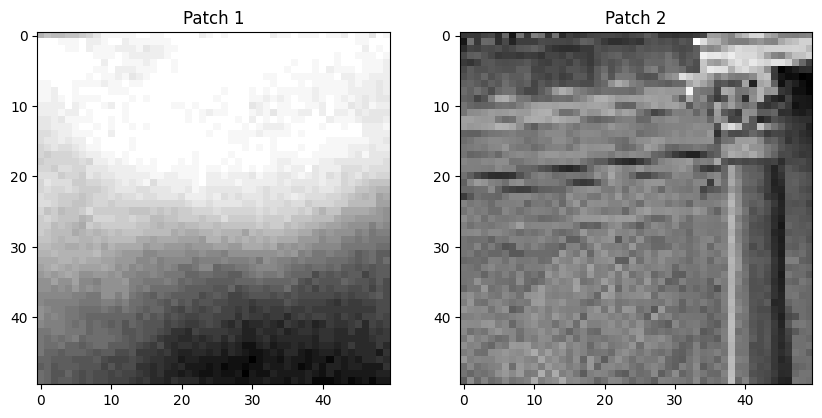

In [16]:
def cross_correlation(f1, f2):
    """
    Computes the cross-correlation between two feature vectors.
    
    Parameters:
    - f1: First feature vector.
    - f2: Second feature vector.
    
    Returns:
    - Cross-correlation value.
    """
    f1 = np.asarray(f1)
    f2 = np.asarray(f2)
    
    # Mean of the vectors
    mean_f1 = np.mean(f1)
    mean_f2 = np.mean(f2)
    
    # Covariance
    cov = np.sum((f1 - mean_f1) * (f2 - mean_f2)) / (len(f1) - 1)
    
    # Variances
    var_f1 = np.sum((f1 - mean_f1) ** 2) / (len(f1) - 1)
    var_f2 = np.sum((f2 - mean_f2) ** 2) / (len(f2) - 1)
    
    # Cross-correlation
    cross_corr = cov / np.sqrt(var_f1 * var_f2)
    
    return cross_corr

def extract_patch(image, center, size):
    """
    Extracts a patch from the image given the center and size.
    
    Parameters:
    - image: The input image.
    - center: The (x, y) center of the patch.
    - size: The (width, height) size of the patch.
    
    Returns:
    - Flattened patch as a feature vector.
    """
    x, y = center
    w, h = size
    patch = image[y - h//2:y + h//2, x - w//2:x + w//2]
    return patch.flatten()

# Load and preprocess an example image
image = cv2.imread('ex_11_Visual_Odometry/sequence/000002.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (600, 400))

# Example patches
center1 = (150, 100)
center2 = (350, 200)
patch_size = (50, 50)

# Extract patches
patch1 = extract_patch(image, center1, patch_size)
patch2 = extract_patch(image, center2, patch_size)

# Compute cross-correlation between the patches
cross_corr_value = cross_correlation(patch1, patch2)

# Print the result
print(f"Cross-correlation between patches: {cross_corr_value}")

# Visualize the patches
patch1_img = patch1.reshape(patch_size)
patch2_img = patch2.reshape(patch_size)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(patch1_img, cmap='gray')
plt.title('Patch 1')

plt.subplot(1, 2, 2)
plt.imshow(patch2_img, cmap='gray')
plt.title('Patch 2')

plt.show()

Number of corners detected: 209


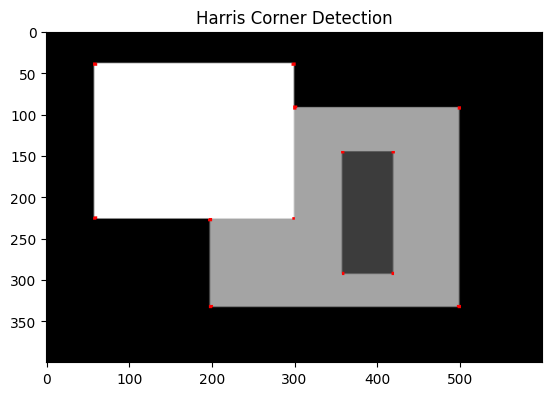

In [25]:
def harris_corner_detection(image, block_size=2, ksize=3, k=0.04):
    """
    Detects corners in an image using the Harris corner detection algorithm.

    Parameters:
    - image: Input image in BGR format.
    - block_size: Size of the neighborhood considered for corner detection.
    - ksize: Aperture parameter of the Sobel derivative used.
    - k: Harris detector free parameter.

    Returns:
    - image_with_corners: Image with detected corners marked in red.
    - num_corners: Number of detected corners.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, block_size, ksize, k)
    dst = cv2.dilate(dst, None)
    
    # Threshold for an optimal value, it may vary depending on the image
    threshold = 0.01 * dst.max()
    corners = np.where(dst > threshold)
    
    # Mark corners in red
    image[dst > threshold] = [0, 0, 255]
    
    num_corners = len(corners[0])
    
    print(f"Number of corners detected: {num_corners}")
    return image, num_corners

# Load image
image = cv2.imread('images/TestIm1.png')
image = cv2.resize(image, (600, 400))

# Detect Harris corners
harris_corners, num_corners = harris_corner_detection(image.copy())

# Show the result
plt.imshow(cv2.cvtColor(harris_corners, cv2.COLOR_BGR2RGB))
plt.title('Harris Corner Detection')
plt.show()